In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.Size([100, 1, 28, 28]) torch.Size([100])


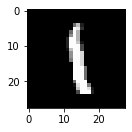

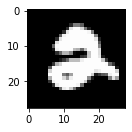

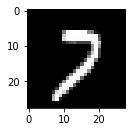

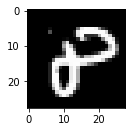

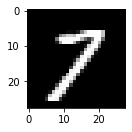

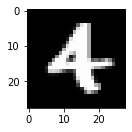

In [13]:
# we will keep feeding the RNN one row at a time 
input_size = 28
# there are 28 such rows in the image
sequence_length = 28

# this means that we will have two layers of nodes stacked in the RNN
num_layers = 2
hidden_size = 128

num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

train_dataset = torchvision.datasets.MNIST(root='./data', train= True,
                                          transform= transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train= False,
                                          transform= transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=0)

test_loader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=0)

examples = iter(train_loader)
samples, lables = next(examples)
print(samples.shape, lables.shape)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
    plt.show()

In [22]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
#         self.rnn = nn.RNN(input_size, hidden_size,num_layers, batch_first = True)
#         self.gru = nn.GRU(input_size, hidden_size,num_layers, batch_first = True)
        self.lstm = nn.LSTM(input_size, hidden_size,num_layers, batch_first = True)
        #  the input x has to be in this format x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # below output will be the out put of all the time steps but we need of only the latest
#         out, _ = self.rnn(x, h_0)
#         out, _ = self.gru(x, h_0)
        out, _ = self.lstm(x, (h_0,c_0))
        # outputs is how dimensions batch_size, seq_length, hiden_size
        # out (N, 28, 128)
        out = out[:,-1,:]
        # out (N, 128)
        out = self.fc(out)
        return out

In [23]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, lables) in enumerate(train_loader):
        # the image datas is 100(batch size) * 1 * 28 * 28 (28 * 28 actual image)
        # that has to be reshaped for the rnn 
        # we need it to be 100(batch size) , 28 sequences of 28 rows of pixels
        images = images.reshape(-1, sequence_length, input_size).to(device)
        lables = lables.to(device)
        
        # forward 
        outputs = model(images)
        loss = criterion(outputs, lables)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}, step {i+1}, loss = {loss.item():.4f}')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i, (images, lables) in enumerate(test_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        lables = lables.to(device)
        outputs = model(images)
        
        _, predictions = torch.max(outputs, 1)
        n_samples  += lables.shape[0]
        n_correct += (predictions == lables).sum().item()
    acc = 100* n_correct / n_samples
    print(f'accuracy ={acc:.4f}')

epoch: 1, step 100, loss = 0.8500
epoch: 1, step 200, loss = 0.3981
epoch: 1, step 300, loss = 0.3067
epoch: 1, step 400, loss = 0.2483
epoch: 1, step 500, loss = 0.1830
epoch: 1, step 600, loss = 0.2011
epoch: 2, step 100, loss = 0.0651
epoch: 2, step 200, loss = 0.0615
epoch: 2, step 300, loss = 0.0637
epoch: 2, step 400, loss = 0.0997
epoch: 2, step 500, loss = 0.0883
epoch: 2, step 600, loss = 0.1093
accuracy =96.2700
